In [1]:
from tensorflow.keras.optimizers import Adam
from keras.utils import Sequence

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

pi = 3.14159265359

maxval=1e9
minval=1e-9

2024-09-13 16:28:12.020673: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 16:28:13.258911: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from dataprep import *
from loss import *
from models import *

In [3]:
model=CreateModel((13,21,20),n_filters=5,pool_size=3)
model.summary()

2024-09-13 16:28:16.880293: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1163 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.5gb, pci bus id: 0000:01:00.0, compute capability: 8.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 21, 20)]      0         
                                                                 
 q_separable_conv2d (QSepar  (None, 11, 19, 5)         285       
 ableConv2D)                                                     
                                                                 
 q_activation (QActivation)  (None, 11, 19, 5)         0         
                                                                 
 q_conv2d (QConv2D)          (None, 11, 19, 5)         30        
                                                                 
 q_activation_1 (QActivatio  (None, 11, 19, 5)         0         
 n)                                                              
                                                                 
 average_pooling2d (Average  (None, 3, 6, 5)           0     

In [4]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=custom_loss)

In [5]:
# get best weights file
pitch = "100x25x150"
files = os.listdir("weights_old/weights-{}-checkpoints".format(pitch))
vlosses = [float(f.split("-v")[1].split(".hdf5")[0]) for f in files]
bestfile = files[np.argmin(vlosses)]
model.load_weights("weights_old/weights-{}-checkpoints/".format(pitch)+bestfile)

# Scaling Lists for Different Pixel Pitches:
* 100x25x100 um:  [150.0, 37.5, 10.0, 1.22]
* 50x25x100 um:   [75.0, 37.5, 10.0, 1.22]
* 50x20x100 um:   [75.0, 30.0, 10.0, 1.22]
* 50x15x100 um:   [75.0, 22.5, 10.0, 1.22]
* 50x12.5x100 um: [75.0, 18.75, 10.0, 1.22]
* 50x10x100 um:   [75.0, 15.0, 10.0, 1.22]

In [7]:
val_batch_size = 5000
val_file_size = 1

test_generator = CustomDataGenerator(
    data_directory_path = "/data/dajiang/smartPixels/dataset_2s/dataset_2s_100x25x150_parquets/unflipped/recon3D/",
    labels_directory_path = "/data/dajiang/smartPixels/dataset_2s/dataset_2s_100x25x150_parquets/unflipped/labels/",
    is_directory_recursive = False,
    file_type = "parquet",
    data_format = "3D",
    batch_size = val_batch_size,
    file_count = val_file_size,
    to_standardize= True,
    include_y_local= False,
    labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'], # added pt to see how pt affects the accuracy
    scaling_list = [150.0, 37.5, 10.0, 1.22],
    input_shape = (20,13,21),
    transpose = (0,2,3,1),
    shuffle=False,
    files_from_end=True
)

Processing Files: 100%|██████████| 1/1 [00:22<00:00, 22.74s/it]


In [8]:
# predicts test data
p_test = model.predict(test_generator)

complete_truth = None
for _, y in test_generator:
    if complete_truth is None:
        complete_truth = y
    else:
        complete_truth = np.concatenate((complete_truth, y), axis=0)

# creates df with all predicted values and matrix elements - 4 predictions, all 10 unique matrix elements
df = pd.DataFrame(p_test,columns=['x','M11','y','M22','cotA','M33','cotB','M44','M21','M31','M32','M41','M42','M43'])

# stores all true values in same matrix as xtrue, ytrue, etc.
df['xtrue'] = complete_truth[:,0]
df['ytrue'] = complete_truth[:,1]
df['cotAtrue'] = complete_truth[:,2]
df['cotBtrue'] = complete_truth[:,3]
df['M11'] = minval+tf.math.maximum(df['M11'], 0)
df['M22'] = minval+tf.math.maximum(df['M22'], 0)
df['M33'] = minval+tf.math.maximum(df['M33'], 0)
df['M44'] = minval+tf.math.maximum(df['M44'], 0)

df['sigmax'] = abs(df['M11'])
df['sigmay'] = np.sqrt(df['M21']**2 + df['M22']**2)
df['sigmacotA'] = np.sqrt(df['M31']**2+df['M32']**2+df['M33']**2)
df['sigmacotB'] = np.sqrt(df['M41']**2+df['M42']**2+df['M43']**2+df['M44']**2)

# calculates residuals for x, y, cotA, cotB
df['residualsX'] = df['xtrue'] - df['x']
df['residualsY'] = df['ytrue'] - df['y']
df['residualsA'] = df['cotAtrue'] - df['cotA']
df['residualsB'] = df['cotBtrue'] - df['cotB']

# calculates pulls for x, y, cotA, cotB
df['pullx'] = (df['xtrue']-df['x'])/df['sigmax']
df['pully'] = (df['ytrue']-df['y'])/df['sigmay']
df['pullcotA'] = (df['cotAtrue']-df['cotA'])/df['sigmacotA']
df['pullcotB'] = (df['cotBtrue']-df['cotB'])/df['sigmacotB']

# stores results as csv
df.to_parquet("{}_timeslices20_dataset2s_vars.parquet".format(pitch))

3/8 [==========>...................] - ETA: 0s 

2024-09-13 16:29:52.259253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-09-13 16:29:52.317748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906


8/8 [==============================] - 6s 112ms/step


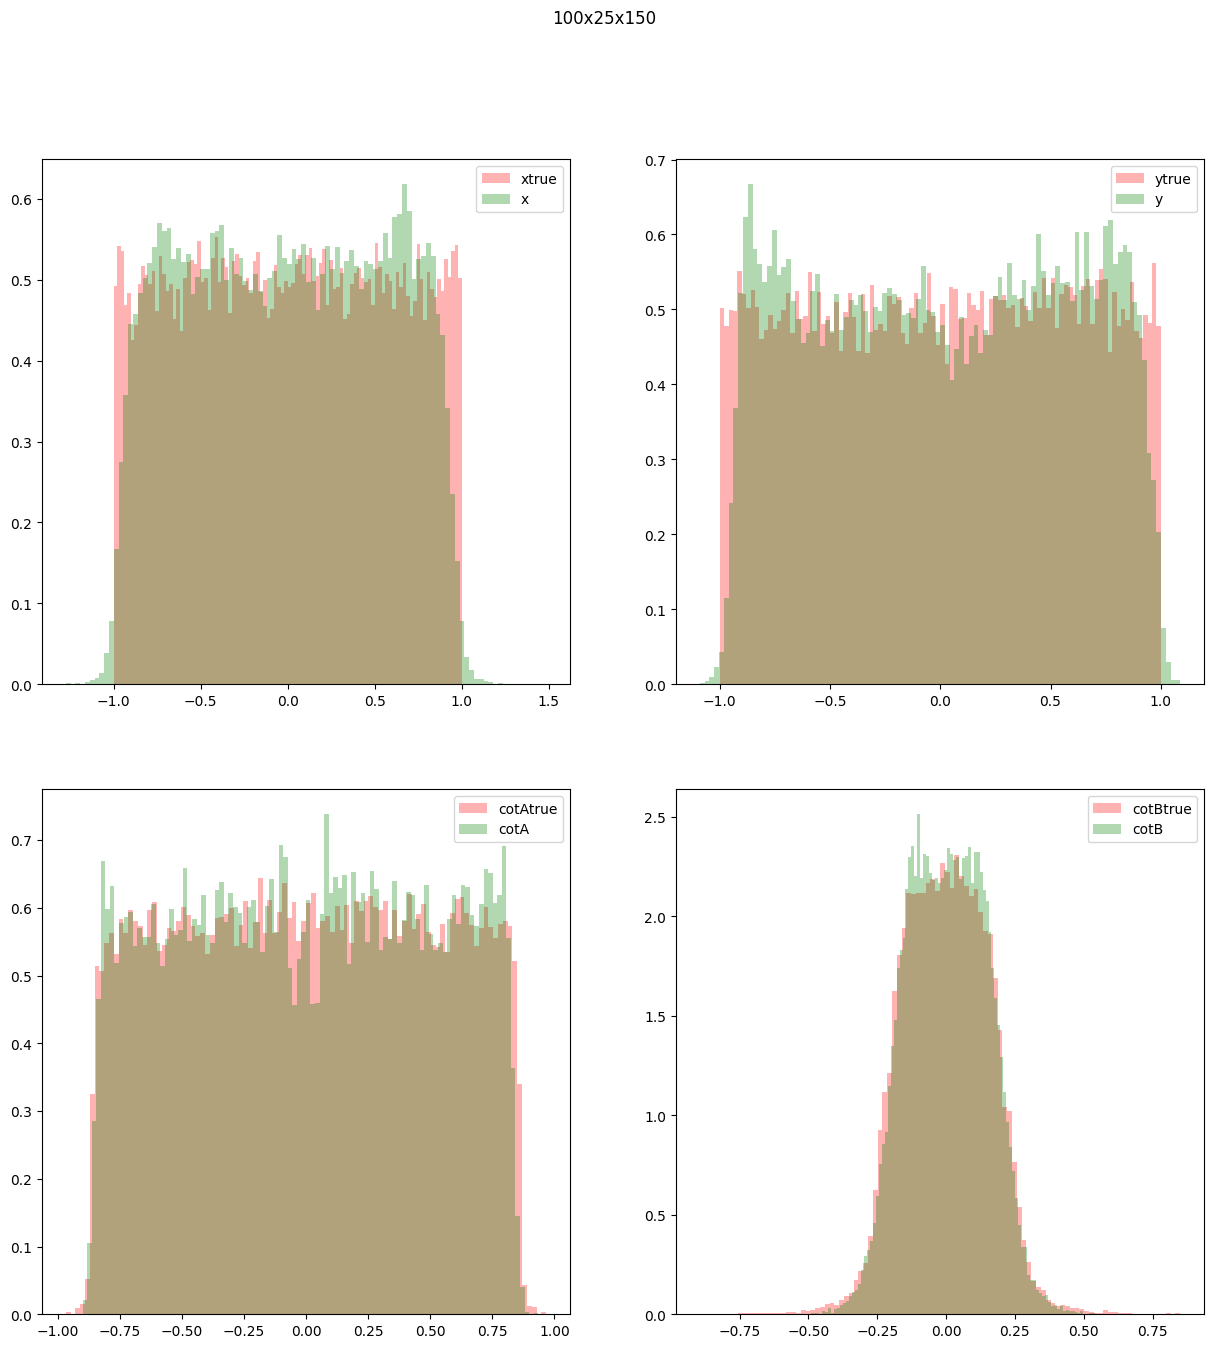

In [34]:
fig, ax = plt.subplots(2,2, figsize=(15,15))

ax[0,0].hist(df['xtrue'], alpha=0.3, bins=100, color='red', density=True, label='xtrue')
ax[0,0].hist(df['x'], alpha=0.3, bins=100, color='green', density=True, label='x')
ax[0,0].legend()
ax[0,1].hist(df['ytrue'], alpha=0.3, bins=100, color='red', density=True, label='ytrue')
ax[0,1].hist(df['y'], alpha=0.3, bins=100, color='green', density=True, label='y')
ax[0,1].legend()
ax[1,0].hist(df['cotAtrue'], alpha=0.3, bins=100, color='red', density=True, label='cotAtrue')
ax[1,0].hist(df['cotA'], alpha=0.3, bins=100, color='green', density=True, label='cotA')
ax[1,0].legend()
ax[1,1].hist(df['cotBtrue'], alpha=0.3, bins=100, color='red', density=True, label='cotBtrue')
ax[1,1].hist(df['cotB'], alpha=0.3, bins=100, color='green', density=True, label='cotB')
ax[1,1].legend()

fig.suptitle(pitch)
fig.show()